# Stay Subway Safe
**How to use this notebook**

Please read through the text interspersed throughout the code. We explain the logic behind each step as you walk through the program.

We have already printed out the results of each cell, so there is no need to re-run cells. However, if you would like to run the code yourself please change file paths to match where you have downloaded the necessary files (both in this notebook and in algorithm.py)

Thank you!

Stay Subway Safe team

## Front End - Interface
To interact with our wireframe (made with JustInMind), click here: https://www.justinmind.com/usernote/tests/47687661/47738106/47746104/index.html

Alternatively, check out the demo video in our Google Drive submission folder.

## Backend, with logic explanations

### User input
**These variable are defined by user input**, as depicted in wireframe.

For this demonstration, values are hard coded and we assume the user wants to know what is happening NOW. Feel free to play with the values here, but remember to modify file paths if you rerun the code.

In [48]:
from datetime import datetime, date, time
import numpy as np

In [49]:
station = "96 ST"
trainline = "1"
date = datetime.date(datetime.now())
time = datetime.time(datetime.now())

### Gather necessary data to fulfill request

In [50]:
import os
import sys
sys.path.insert(0, os.path.abspath(r'C:\Users\Raayan\Documents\GitHub\MassTransit'))
# r'/Users/mehrkaur/Documents/projects/subway/MassTransit'

In [51]:
from get_station_csv import get_final_station_data
from sort_by_week_day import sort_all_days
from h4_chunks_in_py import entries_exits_in_4h_chunks

We scrape the most recent week's data for this requested station...

In [52]:
get_final_station_data(1, station, trainline)

...then sort that data by day of the week and create individual csv files.

In [55]:
sort_all_days(station)

If the user's requested day is a weekday, the prediction will be based on average crowd size across all weekdays from the previous week during the requested time window. This mitigates the impact of anomolies from the previous week on the prediction. 

If the user requests info for a Saturday or Sunday, we look specifically at the previous Saturday or Sunday. This is because the MTA runs fewer trains on Sundays than other days of the week, and ridership differs significantly on each of these days.

In [56]:
requestedDay = date.weekday()
weekDays = ("Mon","Tue","Wed","Thu","Fri","Sat","Sun")

We use our other modules to get the number of train arrivals and number of turnstile entries per hour.

Train arrivals are specific to the day of the week but not the date. we will get this value now so that we don't have to call it multiple times in the loop below. However, turnstile entries are date specific, so we will call when we need it.

In [57]:
from train_info_from_schedule import single_frequency
from entries_exits import get_entry_exit_given_hour

In [58]:
stops_path = r'C:\Users\Raayan\Documents\GitHub\MassTransit\google_transit\stop_times.txt'#r'/Users/mehrkaur/Documents/projects/subway/MassTransit/google_transit/stop_times.txt'
trips_path = r'C:\Users\Raayan\Documents\GitHub\MassTransit\google_transit\trips.txt'#r'/Users/mehrkaur/Documents/projects/subway/MassTransit/google_transit/trips.txt'
stop_id = "120" #HARDCODED for 96th, our pilot

#train schedule is recorded only between 6 am ('06') and 11 pm ('23') to make room for cleaning
#also, time needs to be formatted to have 2 digits
hourINT = time.hour
if (hourINT < 6):
    hour = "06"
elif (hourINT > 23):
    hour = "23"
elif (hourINT < 10):
    hour = "0" + str(hourINT)
else:
    hour = str(hourINT)

#train schedule data is split into weekday, Saturday, Sunday
if(requestedDay <= 4):
    day_type = "Weekday"
elif(requestedDay == 5):
    day_type = "Saturday"
else:
    day_type = "Sunday"



northTrains = single_frequency(stops_path,trips_path,stop_id,hour,day_type,"Northbound")
southTrains = single_frequency(stops_path,trips_path,stop_id,hour,day_type,"Southbound")

trainsPerPlatform = np.array([northTrains, southTrains])

#the red section below is not an error. It is a warning related to accessing files in your computer (but don't worry about it)

We reformat time as needed to get turnstile entry information below.

time_input should be in 24 hr hh:mm 

In [60]:
mins = str(time.minute)
if(len(mins) == 1):
    mins = "0" + mins

time_input = hour + ":" + mins

#our turnstile data is available from 06:00 - 20:59
#we already account for 06:00 bound above, we need to now account for 20:59 bound here.
if(hourINT > 20):
    time_input = "20:59"

### The meat and potatoes: The Algorithm

1) totalEntries = get total station entries in that time chunk

2) entriesPerPlatform = totalEntries / # of platforms

3) trainsPerPlatform = a list of the number of trains arriving to each relavent platform in the time window

4) predictedCrowds = entriesPerPlatform / trainsPerPlatform 
    a list of max crowd size for each platform
    
5) return predictedCrowds to interface

This algorithm tells the user how large, on average, crowd size becomes before the train arrives.


96th street has 2 in service island platforms https://en.wikipedia.org/wiki/96th_Street_station_(IRT_Broadway%E2%80%93Seventh_Avenue_Line) 
We hardcode this value for the pilot program

In [61]:
totalEntries = 0
totalExits = 0 #throw-away value
predictedCrowds = np.array([0,0]) #HARDCODED for 96th. 2 platforms, 2 crowd predictions.

if(requestedDay <= 4): #is a work day
    sumCrowds = np.array([0,0]) #HARDCODED for 96
    for i in range (0,5):
        filename = weekDays[i] + ".csv"
        path = r'C:/Users/Raayan/Documents/GitHub/MassTransit/'+filename #r"/Users/mehrkaur/Documents/projects/subway/MassTransit/" + filename
        totalEntries, totalExits = get_entry_exit_given_hour(path,time_input) 
        if(station == '96 ST'): #currently we are only working with one sheet
            entriesPerPlatform = (totalEntries / 2) + totalExits #HARDCODED, num. platforms at 96th, and transfer split

            tempCrowds = entriesPerPlatform / trainsPerPlatform
            sumCrowds = sumCrowds + tempCrowds
        
        else:
            entriesPerPlatform = totalEntries / 2 #HARDCODED, num. platforms at non-transfer stations

            tempCrowds = entriesPerPlatform / trainsPerPlatform
            sumCrowds = sumCrowds + tempCrowds

    predictedCrowds = sumCrowds / 5 #avg over 5 work days
         
else: #is weekend
    filename = weekDays[requestedDay] + ".csv"
    path = r'C:/Users/Raayan/Documents/GitHub/MassTransit/' + filename #'/Users/mehrkaur/Documents/projects/subway/MassTransit/' + filename
    totalEntries, totalExits = get_entry_exit_given_hour(path,time_input)
    entriesPerPlatform = totalEntries / 2 #HARDCODED, num. platforms at 96th

    predictedCrowds = entriesPerPlatform / trainsPerPlatform

In [62]:
print(totalEntries)
print(predictedCrowds)

638.5
[34.676 34.676]


predictedCrowds is the return value of the algorithm

### Grader
Color codes the returned crowd size depending on the size of the selected platforms.

risk level 1 = green | 2 = yellow | 3 = orange | 4 = red

In [13]:
platformDensities = np.array([0,0])
platform_length = 510
platform_width = 12.5
platform_size = (platform_length * platform_width) / 2 #assume half the platform is unusable space (walls, stairs, etc)
if (predictedCrowds.size != 0):
    #length = len(predictedCrowds)
    platformDensities = np.array([0,0]) #HARDCODED, 2 platforms in 96th = 2 elements
    for i in range(0,predictedCrowds.size):
        if predictedCrowds[i]: 
            density = platform_size / predictedCrowds[i] #square feet per person
        else: density = 0
        platformDensities[i] = density
else: platformDensities = predictedCrowds

platformGrades = np.array(["0","0"]) #0 represents no data
green = 64 #at least 8 feet per person in all directions
yellow = 36 #at least 6 feet (CDC recommendation) 
orange = 16 #at least 4 feet 
if (platformDensities.size != 0):
    #length = len(platformDensities)
    platformGrades = np.array([0,0])
    for i in range(0,platformDensities.size):
        if platformDensities[i]:
            if(platformDensities[i] >= green):
                platformGrades[i] = 1
            elif(platformDensities[i] >= yellow):
                platformGrades[i] = 2
            elif(platformDensities[i] >= orange):
                platformGrades[i] = 3
            else:
                platformGrades[i] = 4
                
        else: platformGrades[i] = 0

## Evidence of functionality

We hope you enjoyed that code walk through! 

All of our code was also formatted as .py modules. We demonstrate how they come together below with examples from our pilot program.

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
from algorithm import get_crowds, grade_crowds

### Visualization of crowd size over types of days
Our categories are Weekday, Saturday, and Sunday as discussed above.

**Graph information:**

- x-axis = time in hours (6 is 6am, 20 is 8pm)
- y-axis = number of people predicted on the platform
    - note: these numbers are especially low now because ridership is down to 25% (see final slide deck)
- legend: orange = southbound platform | blue = northbound platform


In [16]:
#get 96 St info
station = "96 ST"
trainline = "1"
date = datetime.date(datetime.now())
time = datetime.time(datetime.now())
get_final_station_data(1, station, trainline)
sort_all_days(station)

In [17]:
#Weekday 96th
from datetime import time
time1=time(6,0,0)
time_list=[]
time_list.append(time1)
for i in range(1,15):
    time_list.append(time(6+i,0,0))
weekday_crowds=[get_crowds(date,time,'120','96 ST') for time in time_list]



C:\Users\Raayan\Documents\GitHub\MassTransit\train_info_from_schedule.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['hour_of_day'][item]=source['arrival_time'][item][:2]
C:\Users\Raayan\Documents\GitHub\MassTransit\entries_exits.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item['ENTRIES']=entries
C:\Users\Raayan\Documents\GitHub\MassTransit\entries_exits.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

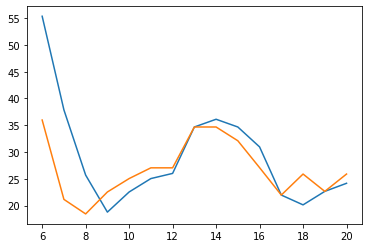

In [18]:
#Weekday forecasts for 96th Street station
entry_forecasts=[]
northbound_forecasts=[]
southbound_forecasts=[]
for item in weekday_crowds:
    entry_forecasts.append(item[0])
    northbound_forecasts.append(item[1][0])
    southbound_forecasts.append(item[1][1])
x_axis=[6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.plot(x_axis,northbound_forecasts)
plt.plot(x_axis,southbound_forecasts)

In [19]:
#Sunday 96th St
from datetime import date,time
time1=time(6,0,0)
time_list=[]
time_list.append(time1)
for i in range(1,15):
    time_list.append(time(6+i,0,0))
date=date(2020,7,26)
sunday_crowds=[get_crowds(date,time,'120','96 ST') for time in time_list]

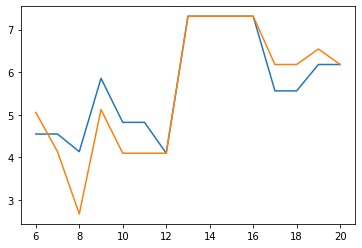

In [20]:
#Sunday forecasts for 96th street station
entry_forecasts=[]
northbound_forecasts=[]
southbound_forecasts=[]
for item in sunday_crowds:
    entry_forecasts.append(item[0])
    northbound_forecasts.append(item[1][0])
    southbound_forecasts.append(item[1][1])
x_axis=[6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.plot(x_axis,northbound_forecasts)
plt.plot(x_axis,southbound_forecasts)

In [21]:
#Saturday 96 St
from datetime import date,time
from datetime import date,time
time1=time(6,0,0)
time_list=[]
time_list.append(time1)
for i in range(1,15):
    time_list.append(time(6+i,0,0))
date=date(2020,7,25)
saturday_crowds=[get_crowds(date,time,'120','96 ST') for time in time_list]

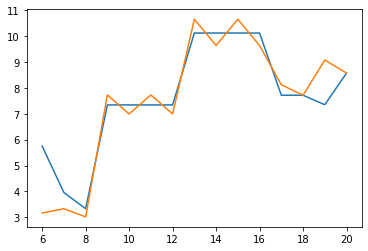

In [22]:
#Saturday forecasts for 96th street station
entry_forecasts=[]
northbound_forecasts=[]
southbound_forecasts=[]
for item in saturday_crowds:
    entry_forecasts.append(item[0])
    northbound_forecasts.append(item[1][0])
    southbound_forecasts.append(item[1][1])
x_axis=[6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.plot(x_axis,northbound_forecasts)
plt.plot(x_axis,southbound_forecasts)

In [23]:
#Change the CSV files to 116 St info
get_final_station_data(1, '116 ST-COLUMBIA', '1')
sort_all_days('116 ST-COLUMBIA')

In [24]:
#Weekday, 116th Street
from datetime import date,time
time1=time(6,0,0)
time_list=[]
time_list.append(time1)
for i in range(1,15):
    time_list.append(time(6+i,0,0))
date=datetime.date(datetime.now())
weekday_crowds=[get_crowds(date,time,'117','116 ST-COLUMBIA') for time in time_list]

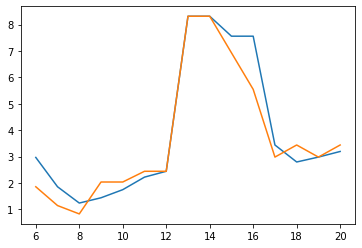

In [25]:
#Weekday for 116th street station
entry_forecasts=[]
northbound_forecasts=[]
southbound_forecasts=[]
for item in weekday_crowds:
    entry_forecasts.append(item[0])
    northbound_forecasts.append(item[1][0])
    southbound_forecasts.append(item[1][1])
x_axis=[6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.plot(x_axis,northbound_forecasts)
plt.plot(x_axis,southbound_forecasts)

In [26]:
#Sunday, 116th Street
from datetime import date,time
time1=time(6,0,0)
time_list=[]
time_list.append(time1)
for i in range(1,15):
    time_list.append(time(6+i,0,0))
date=date(2020,7,26)
sunday_crowds=[get_crowds(date,time,'117','116 ST-COLUMBIA') for time in time_list]

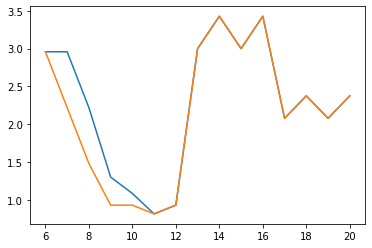

In [27]:
#Weekday for 116th street station
entry_forecasts=[]
northbound_forecasts=[]
southbound_forecasts=[]
for item in sunday_crowds:
    entry_forecasts.append(item[0])
    northbound_forecasts.append(item[1][0])
    southbound_forecasts.append(item[1][1])
x_axis=[6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.plot(x_axis,northbound_forecasts)
plt.plot(x_axis,southbound_forecasts)

In [28]:
#Saturday, 116th Street
from datetime import date,time
time1=time(6,0,0)
time_list=[]
time_list.append(time1)
for i in range(1,15):
    time_list.append(time(6+i,0,0))
date=date(2020,7,25)
saturday_crowds=[get_crowds(date,time,'117','116 ST-COLUMBIA') for time in time_list]


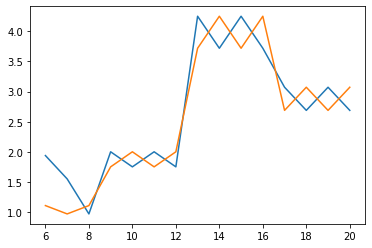

In [29]:
#Saturday for 116th street station
entry_forecasts=[]
northbound_forecasts=[]
southbound_forecasts=[]
for item in saturday_crowds:
    entry_forecasts.append(item[0])
    northbound_forecasts.append(item[1][0])
    southbound_forecasts.append(item[1][1])
x_axis=[6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.plot(x_axis,northbound_forecasts)
plt.plot(x_axis,southbound_forecasts)

### Crowd size on individual platforms throughout the day
(Hardcoded values for demonstration)

We will look at predictions throughout the day on Tuesday, July 28, 2020.

If you are looking at this document after the week of July 28, 2020 and would like to play with the code, please update the date to a date in your current week. This is because our algorithm is based on ridership the week prior to requested date, so the necessary data will have become unavailable.

**At 6 am:**

In [39]:
from datetime import date,time
dateRequest = date(2020,7,28)

timeRequest = time(6,0,0)
entries, crowdSize = get_crowds(dateRequest,timeRequest,'120','96 ST')
crowdRank = grade_crowds(crowdSize)

print("There are " + str(crowdSize[0]) + " people on the Northbound platform.")
print("The Northbound platform is at risk level " + str(crowdRank[0]) + ".")
print("There are " + str(crowdSize[1]) + " people on the Southbound platform.")
print("The Southbound platform is at risk level " + str(crowdRank[1]) + ".")

There are 10.436538461538461 people on the Northbound platform.
The Northbound platform is at risk level 4.
There are 6.78375 people on the Southbound platform.
The Southbound platform is at risk level 4.


**At 8 am:**

In [33]:
timeRequest = time(8,0,0)
entries, crowdSize = get_crowds(dateRequest,timeRequest,'120','96 ST')
crowdRank = grade_crowds(crowdSize)

print("There are " + str(crowdSize[0]) + " people on the Northbound platform.")
print("The Northbound platform is at risk level " + str(crowdRank[0]) + ".")
print("There are " + str(crowdSize[1]) + " people on the Southbound platform.")
print("The Southbound platform is at risk level " + str(crowdRank[1]) + ".")

There are 4.845535714285715 people on the Northbound platform.
The Northbound platform is at risk level 4.
There are 3.478846153846154 people on the Southbound platform.
The Southbound platform is at risk level 4.


**At 12 pm:**

In [34]:
timeRequest = time(12,0,0)
entries, crowdSize = get_crowds(dateRequest,timeRequest,'120','96 ST')
crowdRank = grade_crowds(crowdSize)

print("There are " + str(crowdSize[0]) + " people on the Northbound platform.")
print("The Northbound platform is at risk level " + str(crowdRank[0]) + ".")
print("There are " + str(crowdSize[1]) + " people on the Southbound platform.")
print("The Southbound platform is at risk level " + str(crowdRank[1]) + ".")

There are 3.582692307692308 people on the Northbound platform.
The Northbound platform is at risk level 4.
There are 3.726 people on the Southbound platform.
The Southbound platform is at risk level 4.


**At 4 pm:**

In [40]:
timeRequest = time(16,0,0)
entries, crowdSize = get_crowds(dateRequest,timeRequest,'120','96 ST')
crowdRank = grade_crowds(crowdSize)

print("There are " + str(crowdSize[0]) + " people on the Northbound platform.")
print("The Northbound platform is at risk level " + str(crowdRank[0]) + ".")
print("There are " + str(crowdSize[1]) + " people on the Southbound platform.")
print("The Southbound platform is at risk level " + str(crowdRank[1]) + ".")

There are 5.213392857142857 people on the Northbound platform.
The Northbound platform is at risk level 4.
There are 4.56171875 people on the Southbound platform.
The Southbound platform is at risk level 4.


**At 12 pm:**

In [41]:
timeRequest = time(20,0,0)
entries, crowdSize = get_crowds(dateRequest,timeRequest,'120','96 ST')
crowdRank = grade_crowds(crowdSize)

print("There are " + str(crowdSize[0]) + " people on the Northbound platform.")
print("The Northbound platform is at risk level " + str(crowdRank[0]) + ".")
print("There are " + str(crowdSize[1]) + " people on the Southbound platform.")
print("The Southbound platform is at risk level " + str(crowdRank[1]) + ".")

There are 2.9241666666666672 people on the Northbound platform.
The Northbound platform is at risk level 4.
There are 3.133035714285714 people on the Southbound platform.
The Southbound platform is at risk level 4.
